In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='whitegrid', color_codes=True)

In [2]:
mpl.rcParams['figure.figsize'] = (10,6)

# Preamble



Type Ia supernovae (SNe Ia) are generally thought to be the thermonuclear disruption of a carbon-oxygen white-dwarf star (WD) in a binary system (see, e.g., Hillebrandt & Niemeyer 2000 for a review), but their formation scenarios and exact progenitor systems are still ambiguous. The photospheric velocity of SNe Ia measured from the strong Si II λ6355 absorption line in their spectrum (e.g., Silverman et al. 2012) at the time of peak brightness is an important parameter for studying the various properties of SNe Ia. The ejecta velocity distribution is also a possible clue for revealing asymmetries in SN Ia explosions. Recent studies reveal that the distribution of SN Ia velocity does not originate from a uniform class. [Wang, X. et al. (2013)](https://arxiv.org/abs/1303.2601) and [Zheng et al. (2018)](https://arxiv.org/abs/1712.01495) show that there exists a subclass of SNe Ia with high velocities (Figures 1 and 2), indicating a different origin for some SNe Ia.

Asymmetric SN Ia explosions could cause different measured ejecta velocities observed from different lines of sight. We intend to model the ejecta velocity of SNe Ia seen from different lines of sight through numerical simulations to test if the simulated velocity distribution could match the observed velocity distribution. We expect the model to demonstrate properties of velocity, ejecta size, and rarity of the high-velocity ejecta compared to the low-velocity. The results of the simulations will be a random sample of the velocity distribution to be compared with the real data.

Due to the limited time alloted for this project, a few descoping option was used. The original method of parameter estimation was MCMC which the posterior of the parameters were difficult to interpret. Further convergence test was needed therefore I decided MCMC was too time consuming. Parameter estimation was descoped form MCMC to grid search which provides a single set of best estimated parameters instead of a posterior. A quality slice in Si II velocity was also made to descope so that the methods matches those in Wang, X. et al. (2013) easily.


# The Data

The data came from [Wang, X. et al (2013) supplementary materials](https://science.sciencemag.org/content/340/6129/170/tab-figures-data). A quality cut in Si II velocity was made to only include velocities between $0.7$ to $1.8$ ($10^4$ $\text{km/s}$). There exist an error column for Si II velocity however was ignored as the errors were suspiciously all integers. Further inquiry from the original author or the original observers (Lick Observatory Supernovae Search) is required to interpret the errors.

In [3]:
def import_sn_data(fpath='sn_data.txt'):
    df = pd.read_csv(fpath, sep='\s+', index_col=0, na_values=['...', 'NaN'])
    df = clean_sn_data(df)
    return df
    
    
def clean_sn_data(df):
    df = (df
          .iloc[:,[0,9]]
          .loc[~df['v_siII'].isnull(), :]
          .loc[(df['v_siII'] > 0.7) & (df['v_siII'] < 1.8)]
         )
    return df

sn_data = import_sn_data()
display(sn_data.head())
display(sn_data.info(verbose=True))
display(sn_data.describe())

,SN_Host,v_siII
SN,,
1998de,NGC252,1.13
1998dk,UGC139,1.27
1998ef,UGC646,1.33
1998es,NGC632,1.18
1999aa,NGC2595,1.04


<class 'pandas.core.frame.DataFrame'>
Index: 153 entries, 1998de to 2008hv
Data columns (total 2 columns):
SN_Host    153 non-null object
v_siII     153 non-null float64
dtypes: float64(1), object(1)
memory usage: 3.6+ KB


None

,v_siII
count,153.000000
mean,1.141438
std,0.150028
min,0.810000
25%,1.040000
50%,1.100000
75%,1.210000
max,1.600000


Here, the right histogram plotted in 

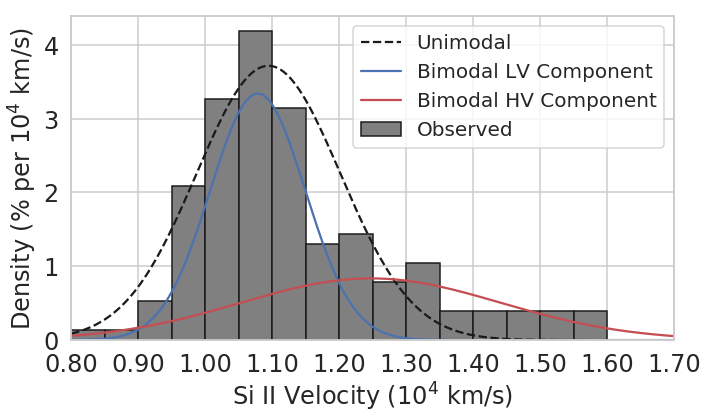

In [144]:
from scipy.optimize import curve_fit
from mcmc import gaussian, bimodal_gaussian

x = sn_data['v_siII']
bins = np.arange(0.8, 1.75, 0.05)
plt.hist(x, density=True, bins=bins, color='gray', fill=True, edgecolor='k', joinstyle='miter', label='Observed')

# Unimodal Gaussian
xrange = np.linspace(bins.min(), bins.max(), 200)
ydata, xdata = np.histogram(x, bins=np.arange(0.8, 1.75, 0.1), density=True)
xdata = (xdata[:-1] + xdata[1:]) / 2
opt, cov = curve_fit(gaussian, xdata, ydata, p0=[np.mean(x), np.std(x)])
plt.plot(xrange, gaussian(xrange, *opt), '--', color='k', label='Unimodal')

# Bimodal Gaussian
opt, cov = curve_fit(bimodal_gaussian, xdata, ydata, p0=[1.1, 1, 1.5, 1, 0.5])
# plt.plot(xrange, bimodal_gaussian(xrange, *opt), color='gray', label='Bimodal')
plt.plot(xrange, opt[4]*gaussian(xrange, *opt[0:2]), 'b', label='Bimodal LV Component')
plt.plot(xrange, (1-opt[4])*gaussian(xrange, *opt[2:4]), 'r', label='Bimodal HV Component')

# Plot config
plt.xticks(bins[::2], [f'{tick:.2f}' for tick in bins[::2]])
plt.xlim(bins.min(), bins.max())
plt.legend(fontsize=20)
plt.xlabel('Si II Velocity ($10^4$ km/s)')
plt.ylabel('Density (% per $10^4$ km/s)')

# Save results
plt.tight_layout()
plt.savefig('velocity_dist.png', orientation='landscape', format='png', dpi=600)
np.savetxt('bimodal_params.txt', opt)

http://mathworld.wolfram.com/SpherePointPicking.html

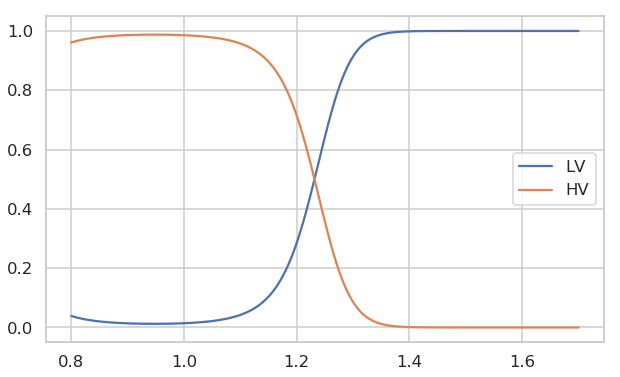

In [5]:
from scipy.stats import norm
from sklearn.mixture import GaussianMixture

clf = GaussianMixture(n_components=2)
clf.fit(x[:,np.newaxis])

p = clf.predict_proba(xrange[:,np.newaxis])
plt.plot(xrange, p[:,0], label='LV')
plt.plot(xrange, p[:,1], label='HV')
plt.legend()

Text(0.5, 0, 'Si II Velocity ($10^4$ km/s)')

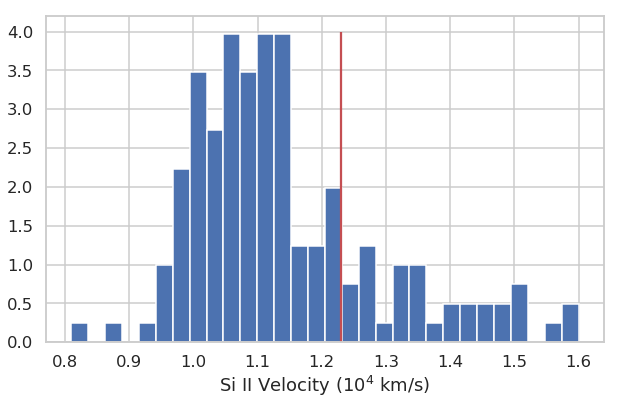

In [6]:
labels = clf.predict(x[:,np.newaxis])
hv = x[labels==1]
lv = x[labels==0]

plt.hist(x, label='Si II Velocity', density=True, bins=30)
boundary = xrange[np.argmin(np.abs(p[:,0] - p[:,1]))]
plt.vlines(boundary, 0, 4, 'r')
# plt.ylim(0,2e-4)

plt.xlabel('Si II Velocity ($10^4$ km/s)')

* MCMC
* KS Grid-search


* 2 or 3 parameters

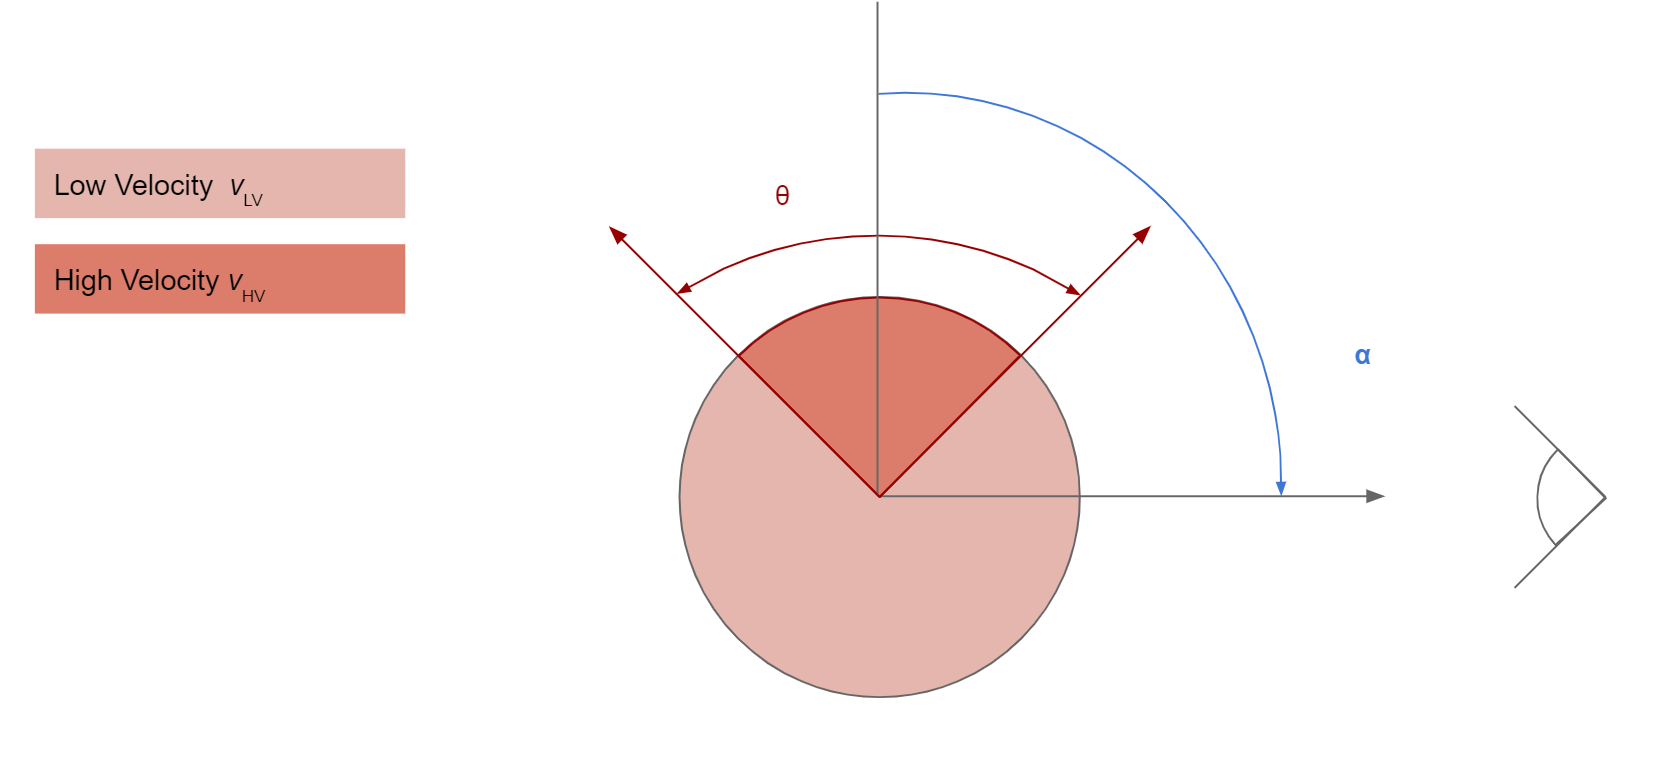

We can classify $D$ to high velocity SNe Ia (HV) and low velocity SNe Ia (LV) by some Bayes optimal rule.

$$
D = \begin{cases} \text{HV} & P(HV \mid D) > P(LV \mid D) \\ \text{LV} & \text{otherwise.} \end{cases}
$$

We wish to determine the posteriors of the parameters $w$ only using HV data,

$$
P(w \mid HV) \propto P(HV \mid w)P(w) 
$$

$$w = [\theta~,\quad \mu_\text{HV}~,\quad \mu_\text{LV}~,\quad \alpha]$$

Where

$$P(HV \mid w) = \prod P(HV \mid w_i)$$

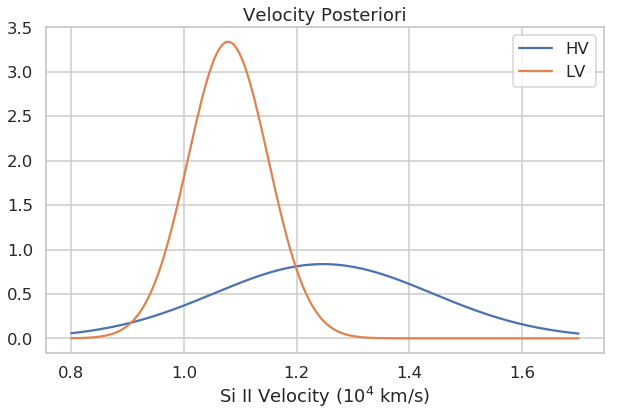

In [7]:
bimodal_params = np.loadtxt('bimodal_params.txt')

def lv_prob(x):
    params = bimodal_params[0:2]
    return gaussian(x, *params)

def hv_prob(x):
    params = bimodal_params[2:4]
    return gaussian(x, *params)

def sample_lv(size=1):
    params = bimodal_params[0:2]
    return np.random.normal(*params, size=size)

def sample_hv(size=1):
    params = bimodal_params[2:4]
    return np.random.normal(*params, size=size)

plt.title('Velocity Posteriori')
plt.plot(xrange, (1-bimodal_params[-1])*hv_prob(xrange), label='HV')
plt.plot(xrange, bimodal_params[-1]*lv_prob(xrange), label='LV')
plt.xlabel('Si II Velocity ($10^4$ km/s)')
plt.legend();

## KS Grid Search

{'mu_HV': 1.3, 'mu_LV': 1.1, 'sigma_HV': 0.25, 'sigma_LV': 0.1, 'theta': 63.35195530726257}
{'mu_HV': 1.3, 'mu_LV': 1.1, 'sigma_HV': 0.25, 'sigma_LV': 0.1, 'theta': 59.32960893854749}
{'mu_HV': 1.3, 'mu_LV': 1.1, 'sigma_HV': 0.25, 'sigma_LV': 0.1, 'theta': 56.312849162011176}
{'mu_HV': 1.3, 'mu_LV': 1.1, 'sigma_HV': 0.25, 'sigma_LV': 0.1, 'theta': 52.29050279329609}
{'mu_HV': 1.3, 'mu_LV': 1.1, 'sigma_HV': 0.2, 'sigma_LV': 0.1, 'theta': 56.312849162011176}
{'mu_HV': 1.3, 'mu_LV': 1.1, 'sigma_HV': 0.2, 'sigma_LV': 0.1, 'theta': 54.30167597765363}
{'mu_HV': 1.3, 'mu_LV': 1.1, 'sigma_HV': 0.2, 'sigma_LV': 0.1, 'theta': 50.27932960893855}
{'mu_HV': 1.3, 'mu_LV': 1.1, 'sigma_HV': 0.2, 'sigma_LV': 0.1, 'theta': 47.262569832402235}
{'mu_HV': 1.3, 'mu_LV': 1.1, 'sigma_HV': 0.15, 'sigma_LV': 0.1, 'theta': 52.29050279329609}
{'mu_HV': 1.3, 'mu_LV': 1.0666666666666667, 'sigma_HV': 0.15, 'sigma_LV': 0.1, 'theta': 109.60893854748603}


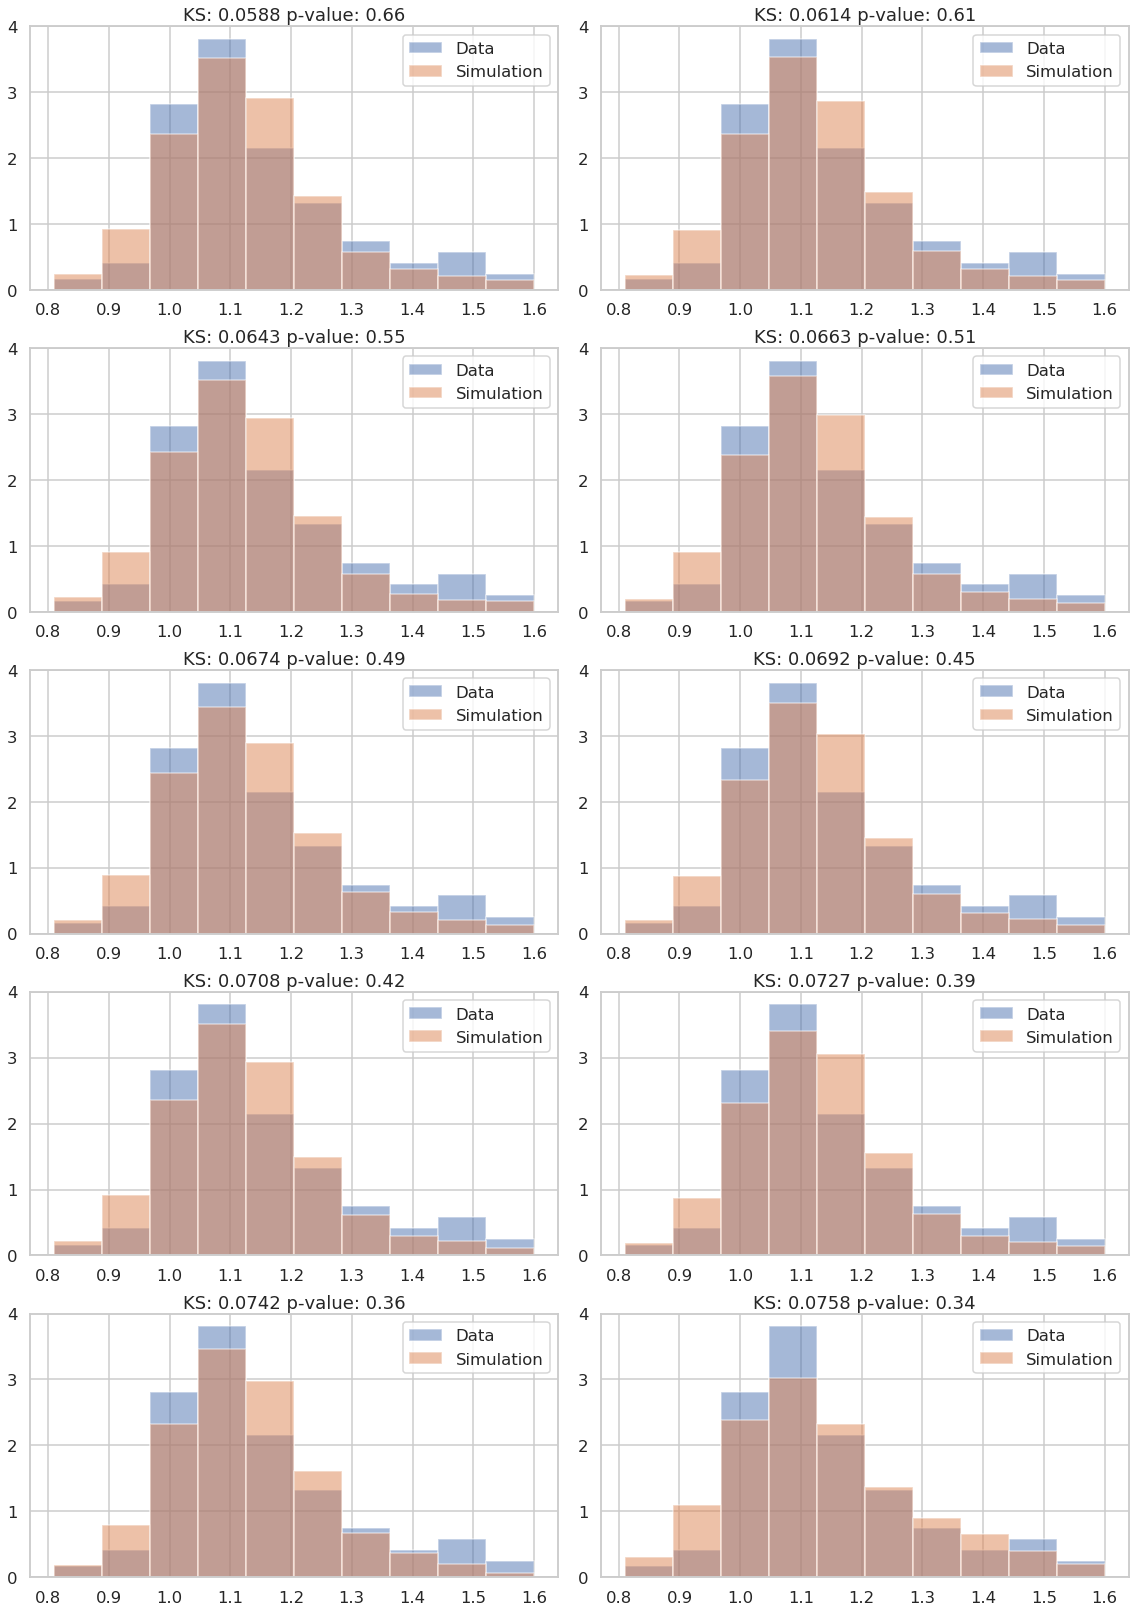

In [55]:
import pickle as pkl

with open('scores.pkl', 'rb') as f:
    scores = pkl.load(f)

sort_idx = np.argsort(scores['ks'])
ks = scores['ks'][sort_idx]
pvalue = scores['pvalue'][sort_idx]
vs = scores['vs'][sort_idx]
params = scores['params'][sort_idx]

nrows, ncols = 5, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(16, 4.5*nrows))

for i in range(nrows*ncols):
    best_vs = vs[i]
    best_ks = ks[i]
    best_pvalue = pvalue[i]
    best_params = params[i]
    print(best_params)
    
    ax = axs[i//ncols, i%ncols]
    bins = np.histogram(sn_data['v_siII'])[1]
    ax.hist(sn_data['v_siII'], bins, density=True, alpha=0.5, label='Data')
    ax.hist(best_vs, bins, density=True, alpha=0.5, label=f'Simulation')
    ax.set_title(f"KS: {best_ks:.4f} p-value: {best_pvalue:.2f}")
    ax.legend()
plt.tight_layout()

In [94]:
len(params)

114

(array([4., 4., 1., 0., 0., 0., 0., 0., 0., 1.]),
 array([ 47.26256983,  53.4972067 ,  59.73184358,  65.96648045,
         72.20111732,  78.43575419,  84.67039106,  90.90502793,
         97.1396648 , 103.37430168, 109.60893855]),
 <a list of 10 Patch objects>)

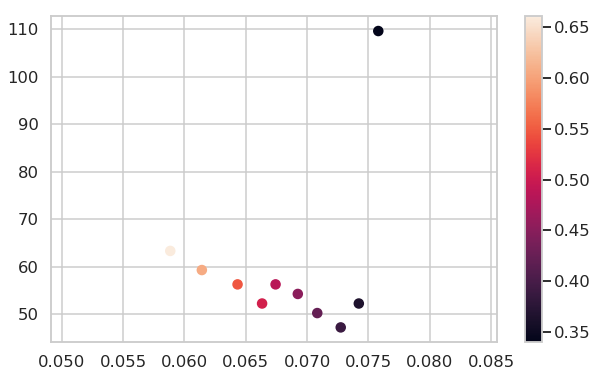

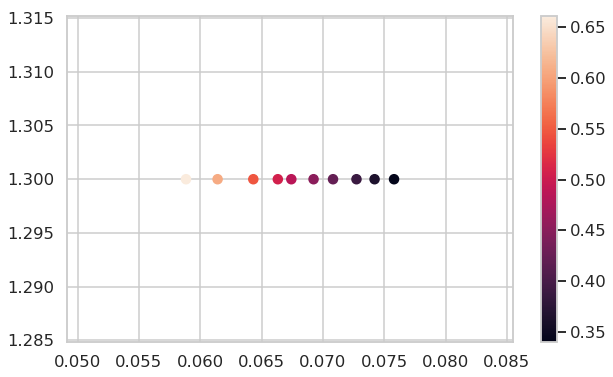

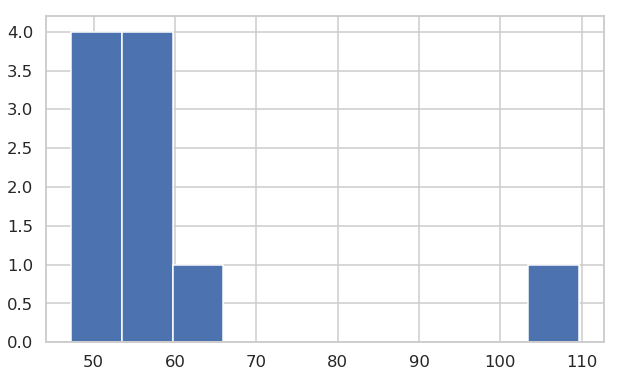

In [93]:
cond = range(10)
thetas = np.array([d['theta'] for d in params])[cond]
mu_HV = np.array([d['mu_HV'] for d in params])[cond]
plt.scatter(ks[cond], thetas, c=pvalue[cond])
plt.colorbar()

plt.figure()
plt.scatter(ks[cond], mu_HV, c=pvalue[cond])
plt.colorbar()

plt.figure()
plt.hist(thetas)

In [140]:
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 24
mpl.rcParams['xtick.labelsize'] = 24
mpl.rcParams['ytick.labelsize'] = 24
mpl.rcParams['legend.fontsize'] = 24

0.05883986928104579
0.6610679406056585
{'mu_HV': 1.3, 'mu_LV': 1.1, 'sigma_HV': 0.25, 'sigma_LV': 0.1, 'theta': 63.35195530726257}


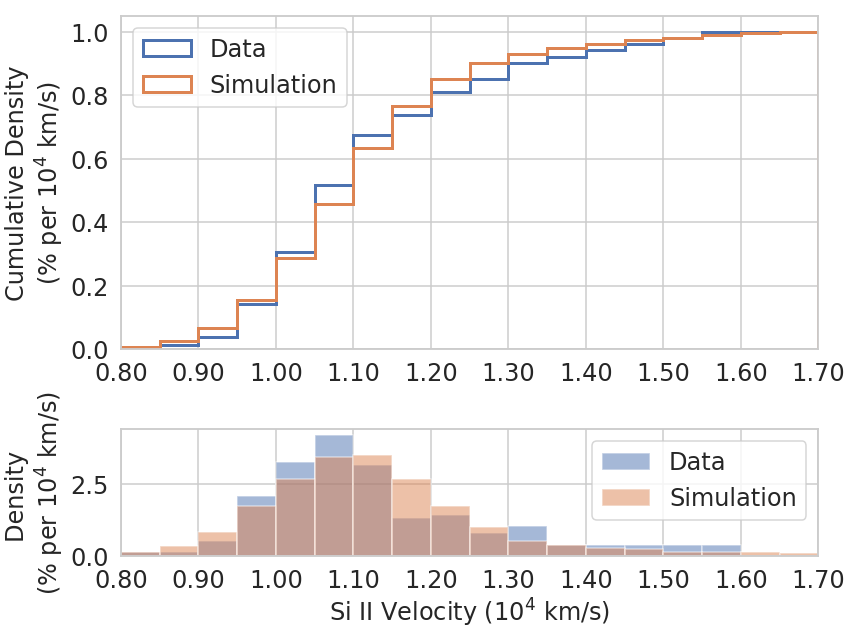

In [166]:
i = 0
best_vs = vs[i]
best_ks = ks[i]
best_pvalue = pvalue[i]
best_params = params[i]

plt.figure(figsize=(12, 9))
ax2 = plt.subplot2grid((3,1), (2,0))
ax1 = plt.subplot2grid((3,1), (0,0), rowspan=2, sharex=ax2)

bins = np.arange(0.8, 1.75, 0.05)
ax2.hist(sn_data['v_siII'], bins, density=True,
         alpha=0.5, label='Data')
ax2.hist(best_vs, bins, density=True, 
         alpha=0.5, label=f'Simulation')
ax2.set_xlabel('Si II Velocity ($10^4$ km/s)')
ax2.set_ylabel('Density \n(% per $10^4$ km/s)')


ax1.hist(sn_data['v_siII'], bins, cumulative=True, histtype='step', 
        density=True, linewidth=3, label='Data')
ax1.hist(best_vs, bins, cumulative=True, histtype='step', 
        density=True, linewidth=3, label=f'Simulation')
ax1.set_ylabel('Cumulative Density\n(% per $10^4$ km/s)')

# Plot config
ax1.legend(loc='upper left')

ax2.set_xticks(bins[::2])
ax2.set_xticklabels([f'{tick:.2f}' for tick in bins[::2]])
ax2.set_xlim(bins.min(), bins.max())
ax2.legend()

plt.tight_layout()
plt.savefig('best.png', dpi=300, format='png')

print(best_ks)
print(best_pvalue)
print(best_params)

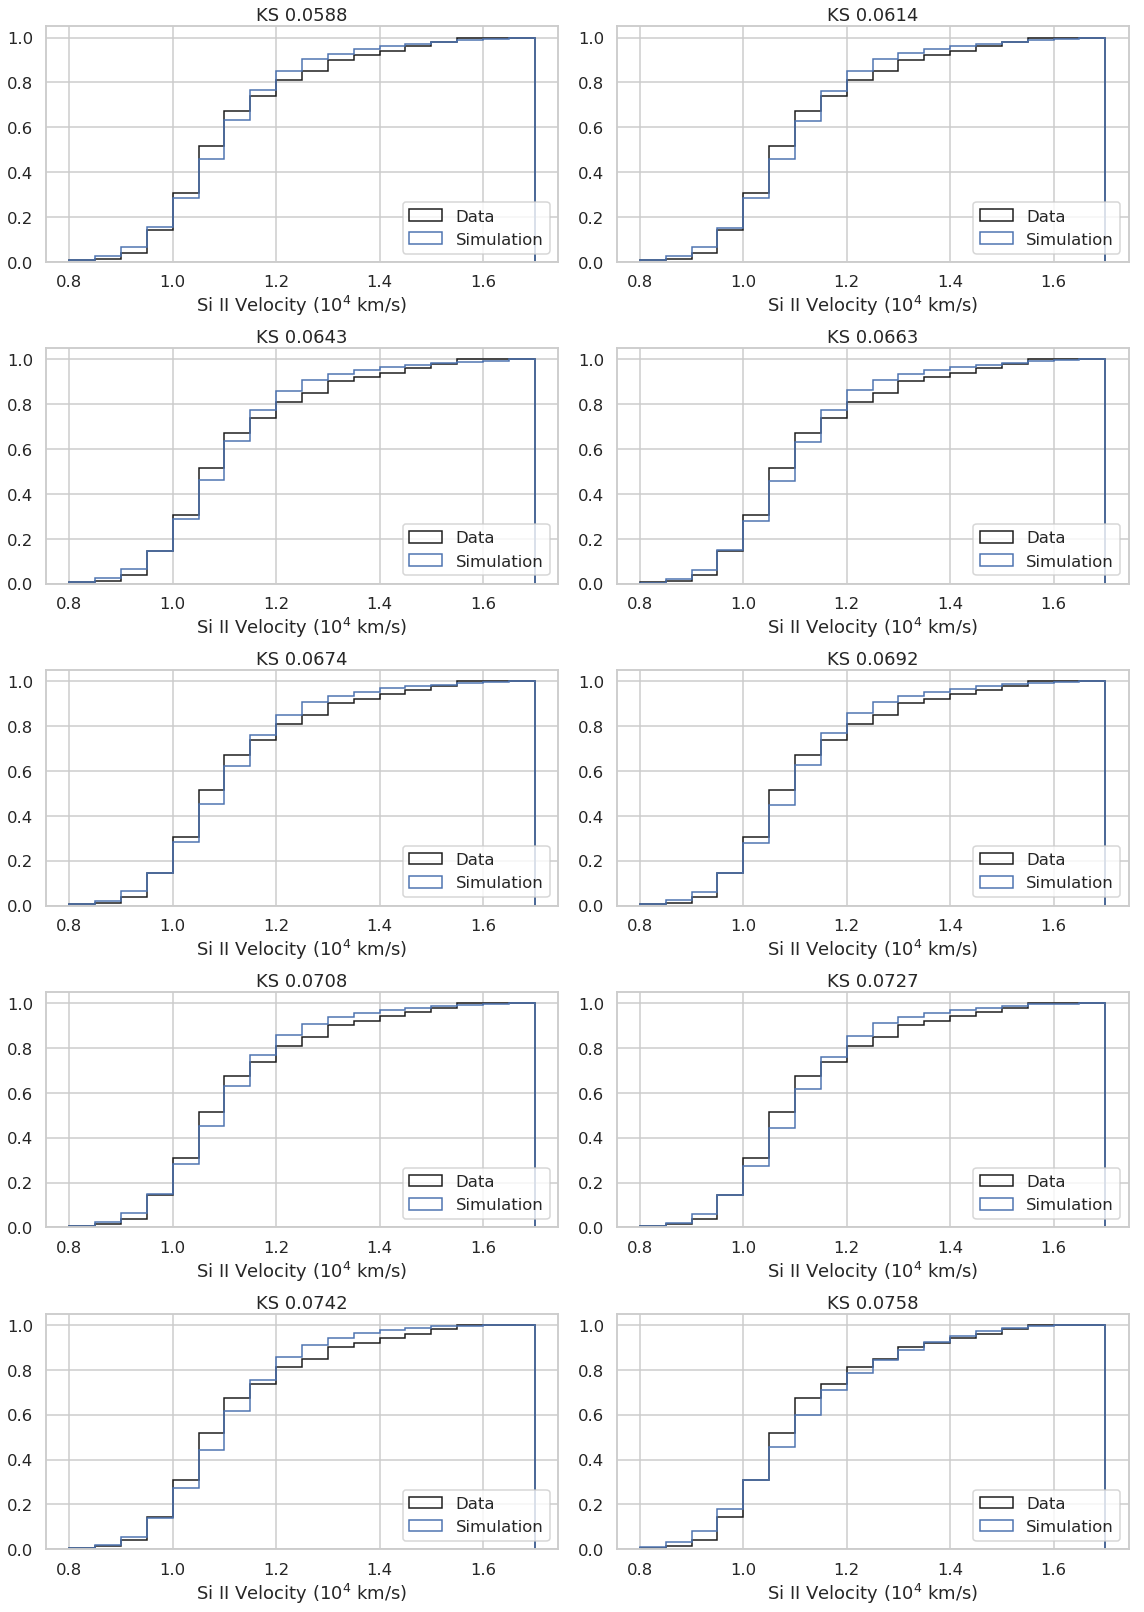

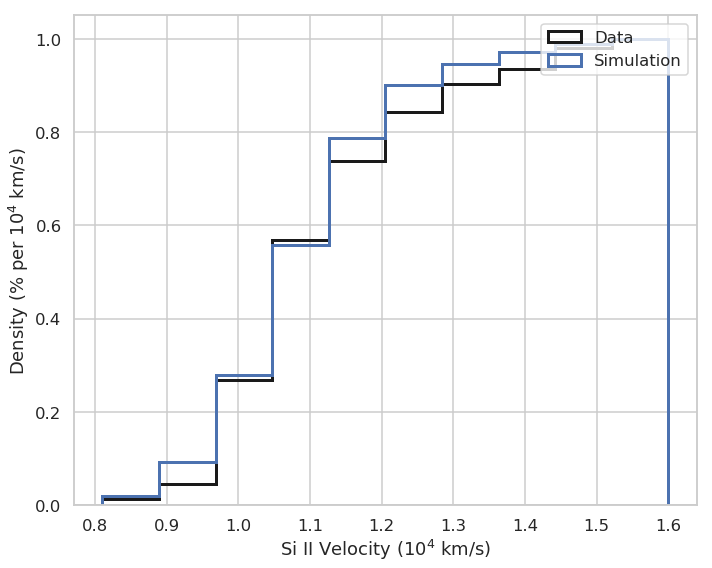

In [106]:
nrows, ncols = 5, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(16, 4.5*nrows))
for i in range(nrows*ncols):
    best_vs = vs[i]
    best_ks = ks[i]
    best_params = params[i]
#     bins = np.histogram(sn_data['v_siII'])[1]
    bins = np.arange(0.8, 1.75, 0.05)
    
    ax = axs[i//ncols, i%ncols]
    ax.hist(sn_data['v_siII'], bins, density=True, histtype='step', cumulative=True, 
            color='lightgray', edgecolor='k', label='Data')
    ax.hist(best_vs, bins, density=True, histtype='step', cumulative=True, 
            label='Simulation')
    
    ax.legend(loc='lower right')
    ax.set_title(f'KS {best_ks:.4f}')
    ax.set_xlabel('Si II Velocity ($10^4$ km/s)')

plt.tight_layout()

i = 0
best_vs = vs[i]
best_ks = ks[i]
best_pvalue = pvalue[i]
best_params = params[i]

plt.figure(figsize=(10,8))
ax = plt.gca()
bins = np.histogram(sn_data['v_siII'])[1]
ax.hist(sn_data['v_siII'], bins, cumulative=True, histtype='step', 
        density=True, linewidth=3, color='lightgray', edgecolor='k', label='Data')
ax.hist(best_vs, bins, cumulative=True, histtype='step', 
        density=True, linewidth=3, label=f'Simulation')
ax.set_xlabel('Si II Velocity ($10^4$ km/s)')
ax.set_ylabel('Density (% per $10^4$ km/s)')
# ax.set_title(f"KS: {best_ks:.4f} p-value: {best_pvalue:.2f}")
ax.legend()

plt.tight_layout()
plt.savefig('best_cumulative.png', dpi=300, format='png')    

## MCMC

See `mcmc.py` for code.

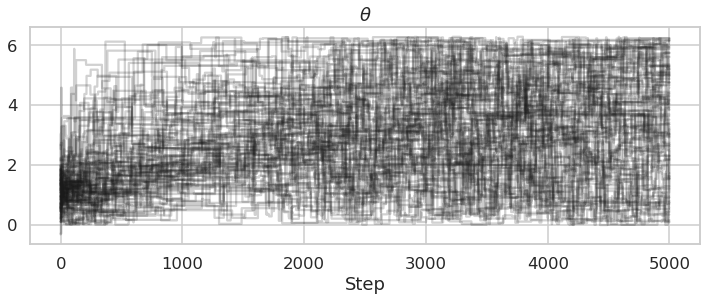

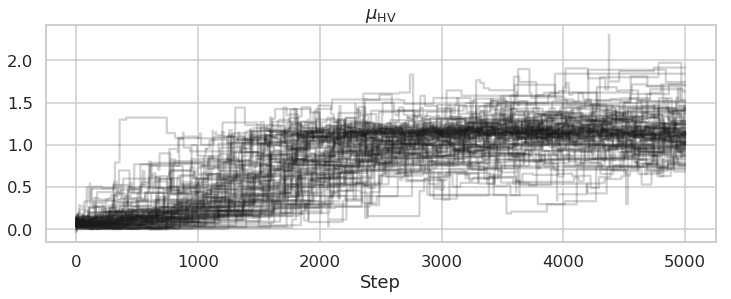

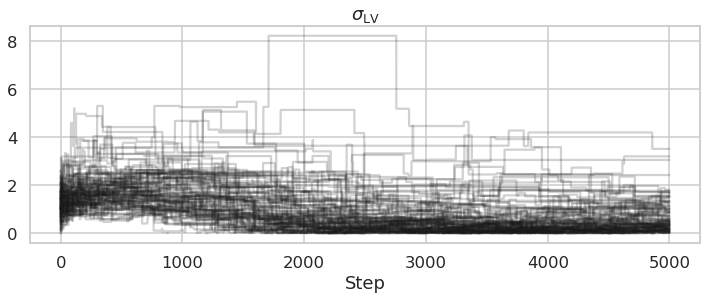

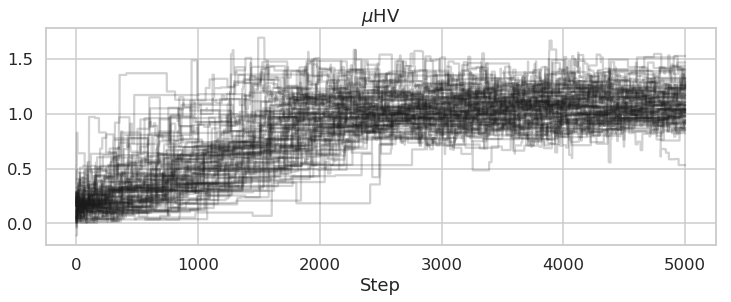

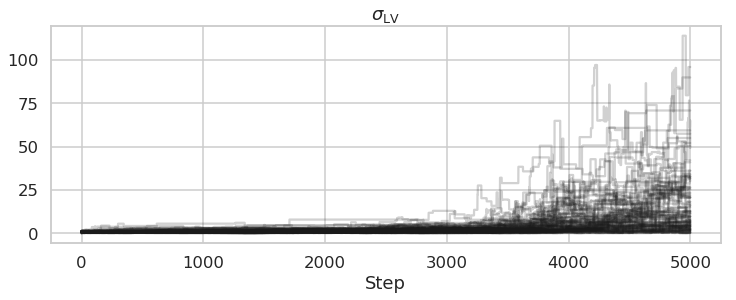

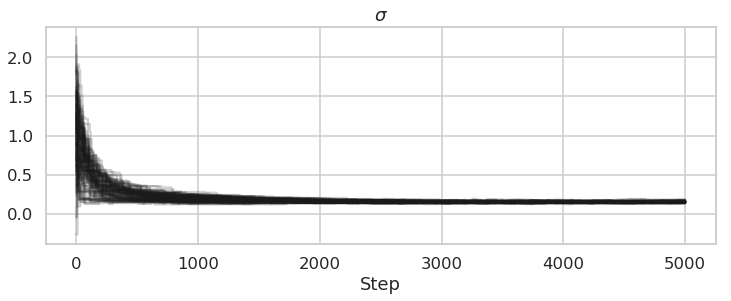

In [14]:
chain = np.load('chain.npy')

labels = [
    r'$\theta$',    
    r'$\mu_\mathrm{HV}$',    
    r'$\sigma_\mathrm{LV}$', 
    r'$\mu\mathrm{HV}$',    
    r'$\sigma_\mathrm{LV}$',
    r'$\sigma$'
] 

for dim_index in range(chain.shape[2]):
    plt.figure(figsize=(12, 4))
    plt.title(labels[dim_index])
    plt.xlabel('Step')
    for walker_index in range(chain.shape[0]):
        plt.plot(chain[walker_index, :, dim_index], 'k-', alpha=0.2)

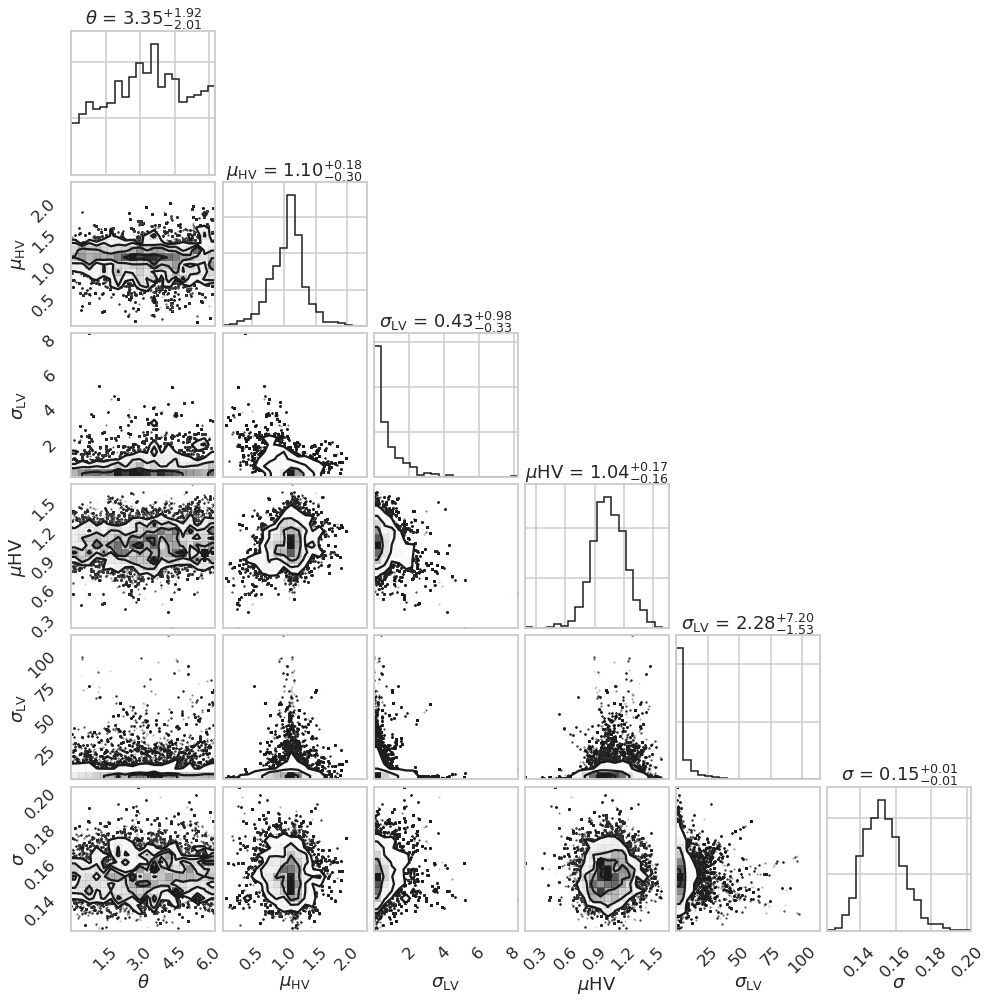

In [17]:
from corner import corner

burnin = 2000
samples = chain[:, burnin:, :].reshape((-1, ndim))
corner(samples, labels=labels, show_titles=True);